In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#Importing GaussianMixture to use its built-in BIC function.
from sklearn.mixture import GaussianMixture

In [7]:
#dfelectricalUsage = pd.read_csv("daily_electricity_usage 2.csv",parse_dates=thedate)
#dfelectricalUsage.count()

dfElectricalUsage = pd.read_csv('daily_electricity_usage.csv', index_col=1, parse_dates=True)
dfElectricalUsage.head()


,Meter ID,total daily KW
date,,
2009-07-14,1000,11.203
2009-07-15,1000,8.403
2009-07-16,1000,7.225
2009-07-17,1000,11.338
2009-07-18,1000,11.306


## Cleaning data

In [8]:
period = pd.date_range(dfElectricalUsage.index.min(), dfElectricalUsage.index.max()) #Date range from first to last date.

"""
Grouping by Meter ID and applying the specified period to each consumer to fill the missing dates, while filling the missing 
values with the mean of the values for the given Meter ID.
"""
dfElectricalUsage = dfElectricalUsage.groupby('Meter ID').apply(lambda x: x.loc[period].fillna(x.mean()))

"""
The dataframe now has a MultiIndex with date and Meter ID. If we reset the index level it will try to insert Meter ID into
the dataframe. This causes a conflict since Meter ID already is a column. Therefore we drop the column before resetting.
"""
#If we reset index level, it will try to insert Meter ID
dfElectricalUsage = dfElectricalUsage.drop('Meter ID', axis = 1).reset_index(level = 0)
dfElectricalUsage.index.name = 'date'

/Users/funkyapps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [9]:
#Test for null columns, if any
null_columns=dfElectricalUsage.columns[dfElectricalUsage.isnull().any()]
print(null_columns)
dfElectricalUsage[null_columns].isnull().sum()

print(dfElectricalUsage[dfElectricalUsage["total daily KW"].isnull()][null_columns])
print(dfElectricalUsage[dfElectricalUsage.index.isnull()][null_columns])

#Test any missing dates in the given time period
pd.date_range(start = '2009-07-14', end = '2010-10-17' ).difference(dfElectricalUsage.index)

Index([], dtype='object')
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [10]:
#dfelectricalUsage.drop_duplicates()   -- there are no duplicates

In [11]:
df = dfElectricalUsage.groupby('Meter ID').nunique()
print("Total # of cunsumers", df.count())

Total # of cunsumers Meter ID          6435
total daily KW    6435
dtype: int64


## Adding calender features to dataset ##

In [12]:
from datetime import date
import calendar
my_date = date.today()
calendar.day_name[my_date.weekday()]

'Saturday'

In [13]:
column_1 = dfElectricalUsage.iloc[:,0]
column_1
#Tried using next line since index_col was changed to 'date'.
#column_1 = dfElectricalUsage.reset_index().set_index('Meter ID').iloc[:,0]
dfElectricalUsage

dfElectricalUsage = pd.DataFrame({"date":dfElectricalUsage.index,
                               "year": dfElectricalUsage.index.year,
                               "month": dfElectricalUsage.index.month,
                               "day": dfElectricalUsage.index.day,
                               "dayofyear": dfElectricalUsage.index.dayofyear,
                               "weekofyear": dfElectricalUsage.index.weekofyear,
                               "weekday": dfElectricalUsage.index.weekday,
                               "weekend": ((pd.DatetimeIndex(dfElectricalUsage.index).dayofweek) // 5 == 1).astype(int),   #integer division to get the weekends
                               "quarter": dfElectricalUsage.index.quarter,
                               "DailyUsage": dfElectricalUsage['total daily KW'],
                               "Meter ID": dfElectricalUsage['Meter ID']})

print(dfElectricalUsage)

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-07-14 2009-07-14  2009      7   14        195          29        1   
2009-07-15 2009-07-15  2009      7   15        196          29        2   
2009-07-16 2009-07-16  2009      7   16        197          29        3   
2009-07-17 2009-07-17  2009      7   17        198          29        4   
2009-07-18 2009-07-18  2009      7   18        199          29        5   
2009-07-19 2009-07-19  2009      7   19        200          29        6   
2009-07-20 2009-07-20  2009      7   20        201          30        0   
2009-07-21 2009-07-21  2009      7   21        202          30        1   
2009-07-22 2009-07-22  2009      7   22        203          30        2   
2009-07-23 2009-07-23  2009      7   23        204          30        3   
2009-07-24 2009-07-24  2009      7   24        205          30        4   
2009-07-25 2009-07-25  20

In [14]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start='2009-07-14', end='2010-10-17')
dfElectricalUsage['Holiday'] = dfElectricalUsage.index.isin(holidays)
dfElectricalUsageOnlyHoliday = dfElectricalUsage[dfElectricalUsage['Holiday']== True]
print(dfElectricalUsageOnlyHoliday)

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-09-07 2009-09-07  2009      9    7        250          37        0   
2009-10-12 2009-10-12  2009     10   12        285          42        0   
2009-11-11 2009-11-11  2009     11   11        315          46        2   
2009-11-26 2009-11-26  2009     11   26        330          48        3   
2009-12-25 2009-12-25  2009     12   25        359          52        4   
2010-01-01 2010-01-01  2010      1    1          1          53        4   
2010-01-18 2010-01-18  2010      1   18         18           3        0   
2010-02-15 2010-02-15  2010      2   15         46           7        0   
2010-05-31 2010-05-31  2010      5   31        151          22        0   
2010-07-05 2010-07-05  2010      7    5        186          27        0   
2010-09-06 2010-09-06  2010      9    6        249          36        0   
2010-10-11 2010-10-11  20

## Segementation code ##

In [15]:
#daily Average per user
print(dfElectricalUsage.head())
dfUserGroup = dfElectricalUsage.groupby('Meter ID')['DailyUsage'].mean().reset_index(name='DailyAvgPerUser')

#Quarterly Average per user
qtly_avg_cols = ['Meter ID', 'Q1Avg', 'Q2Avg', 'Q3Avg', 'Q4Avg']
dfUserGroup2 = dfElectricalUsage.groupby(['Meter ID','quarter'])['DailyUsage'].mean().reset_index(name='qtlylyAvg')
dfUserGroup2 = dfUserGroup2.pivot(index = 'Meter ID', columns = 'quarter')['qtlylyAvg'].reset_index()
dfUserGroup2.columns = qtly_avg_cols

# Weekday Average per user
weekday_avg_cols = ['Meter ID', 'MonAvg', 'TueAvg', 'WedAvg', 'ThursAvg','FriAvg','SatAvg','SunAvg']
dfUserGroup3 = dfElectricalUsage.groupby(['Meter ID','weekday'])['DailyUsage'].mean().reset_index(name='weekdayAvg')
dfUserGroup3 = dfUserGroup3.pivot(index = 'Meter ID', columns = 'weekday')['weekdayAvg'].reset_index()
dfUserGroup3.columns = weekday_avg_cols

#Monthly average per user
month_avg_cols = ['Meter ID', 'janAvg', 'febAvg', 'marAvg', 'aprAvg', 'mayAvg', 'junAvg', 'julAvg', 'augAvg', 'sepAvg', 'octAvg', 'novAvg', 'desAvg']
dfUserGroup4 = dfElectricalUsage.groupby(['Meter ID', 'month'])['DailyUsage'].mean().reset_index(name='monthlyAverage')
dfUserGroup4 = dfUserGroup4.pivot(index = 'Meter ID', columns = 'month')['monthlyAverage'].reset_index()
dfUserGroup4.columns = month_avg_cols

#Weekend average
dfElectricalUsage['weekend'] = dfElectricalUsage['weekend'].map( lambda x : 1 if x == 0 else x)
dfWeekendAverage = dfElectricalUsage.groupby(['Meter ID','weekend'])['DailyUsage'].mean().reset_index(name='weekendAvg')
dfWeekendAverage = dfWeekendAverage.drop('weekend', 1)

# Merging groups to one dataframe
dfElectricityUsage1 = pd.merge(dfUserGroup,dfUserGroup2,on='Meter ID')
dfElectricityUsage2 = pd.merge(dfElectricityUsage1,dfUserGroup3,on='Meter ID')
dfElectricityUsage3 = pd.merge(dfElectricityUsage2,dfUserGroup4,on='Meter ID')
dfElectricityUsage = pd.merge(dfElectricityUsage3,dfWeekendAverage,on='Meter ID')

dfElectricityUsage


                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-07-14 2009-07-14  2009      7   14        195          29        1   
2009-07-15 2009-07-15  2009      7   15        196          29        2   
2009-07-16 2009-07-16  2009      7   16        197          29        3   
2009-07-17 2009-07-17  2009      7   17        198          29        4   
2009-07-18 2009-07-18  2009      7   18        199          29        5   

            weekend  quarter  DailyUsage  Meter ID  Holiday  
date                                                         
2009-07-14        0        3      11.203      1000    False  
2009-07-15        0        3       8.403      1000    False  
2009-07-16        0        3       7.225      1000    False  
2009-07-17        0        3      11.338      1000    False  
2009-07-18        1        3      11.306      1000    False  


,Meter ID,DailyAvgPerUser,Q1Avg,Q2Avg,Q3Avg,Q4Avg,MonAvg,TueAvg,WedAvg,ThursAvg,...,aprAvg,mayAvg,junAvg,julAvg,augAvg,sepAvg,octAvg,novAvg,desAvg,weekendAvg
0,1000,10.290438,12.184656,7.886923,8.704567,12.026440,10.029066,10.493675,10.596247,9.203974,...,8.411233,7.646516,7.611033,8.431796,8.774016,8.855567,10.584613,11.252267,14.217468,10.290438
1,1001,9.496968,6.740656,4.393681,5.030871,17.519630,9.461461,9.494429,9.446922,9.659545,...,5.030867,4.091355,4.068900,5.050061,4.959355,5.089100,5.178452,11.673000,35.518839,9.496968
2,1002,9.986623,11.041756,9.663022,9.457491,10.122315,11.068092,10.070377,11.133766,10.555091,...,8.100100,10.225839,10.644367,9.943857,9.244500,9.280383,8.675387,11.422967,10.310548,9.986623
3,1003,30.420860,34.442156,29.878198,26.478684,32.385957,31.205987,29.749117,30.104987,30.415584,...,32.629533,32.622774,24.290800,26.464633,25.851242,27.138517,29.507403,32.247150,35.398839,30.420860
4,1004,47.250825,45.986500,41.709725,48.071123,49.847337,48.756053,46.630390,47.364740,44.976065,...,37.611300,45.338000,42.058933,45.918694,47.645984,50.268250,48.738435,49.455483,51.335452,47.250825
5,1005,29.968106,39.393122,22.774330,22.066216,36.259440,29.647855,30.446221,30.518545,28.193481,...,21.622033,23.676968,22.993900,22.216592,20.610516,23.447633,27.614290,37.748383,43.463677,29.968106
6,1006,21.490522,29.277178,12.955681,15.665778,27.316082,22.084829,21.356779,20.089506,21.061727,...,17.202033,15.096097,6.497567,14.505694,15.255452,17.037183,21.187419,25.486700,35.215113,21.490522
7,1007,34.972277,39.328789,35.156824,31.545749,35.934540,33.781329,32.209870,33.279325,33.291107,...,33.964867,34.925968,36.587333,28.262041,34.448919,31.227500,31.855887,36.185800,39.770037,34.972277
8,1008,35.155172,41.770378,30.745473,28.936544,39.879626,34.853908,36.030545,34.398909,32.706974,...,34.497233,29.669387,28.105667,28.417388,28.201677,30.119883,34.076661,38.891633,46.638712,35.155172
9,1009,40.108558,41.688656,29.571176,37.983398,46.522120,37.402803,39.876870,39.290675,40.590494,...,30.650067,28.860161,29.227000,34.060245,38.973952,40.163733,43.952226,46.779183,48.843242,40.108558


## K-Means Clustering##


In [16]:
import matplotlib.pyplot as plt  
%matplotlib inline
import numpy as np  
from sklearn.cluster import KMeans  

In [17]:
dfElectricityUsage = dfElectricityUsage.round(3)
averages = dfElectricityUsage.iloc[:,1:].values

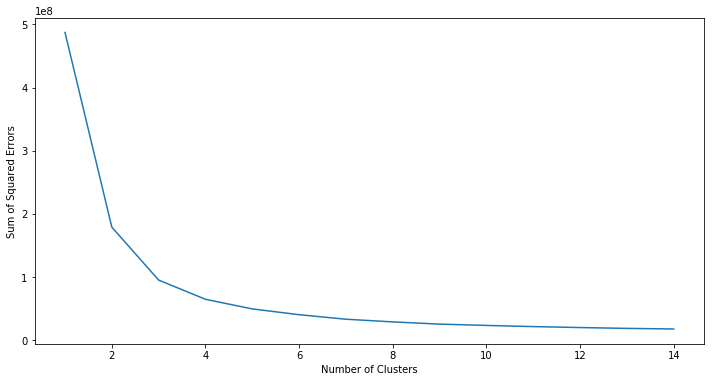

In [18]:
features = averages #Extracting the features from the dataset.
SSE = {}
for k in range(1, 15):
    model = KMeans(n_clusters = k).fit(features) #Creating the model and fitting it with feature data.
    SSE[k] = model.inertia_

#Plotting with the sum of squared errors on the y-axis, and the number of clusters on the x-axis.
plt.figure(figsize = (12,6))
plt.plot(list(SSE.keys()), list(SSE.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.show()


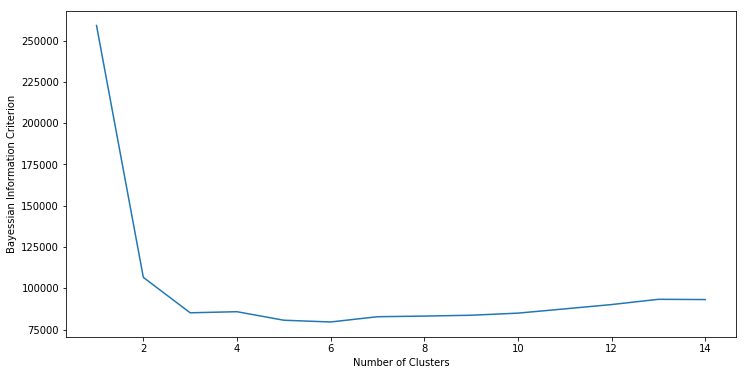

In [19]:
BIC = {}

for k in range(1, 15):
    model = GaussianMixture(n_components = k, init_params = 'kmeans').fit(features)
    BIC[k] = model.bic(features)

plt.figure(figsize = (12,6))
plt.plot(list(BIC.keys()), list(BIC.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Bayessian Information Criterion")
plt.show()

Cluster 0 number of consumers 3949
Cluster 1 number of consumers 32
Cluster 2 number of consumers 92
Cluster 3 number of consumers 259
Cluster 4 number of consumers 2103


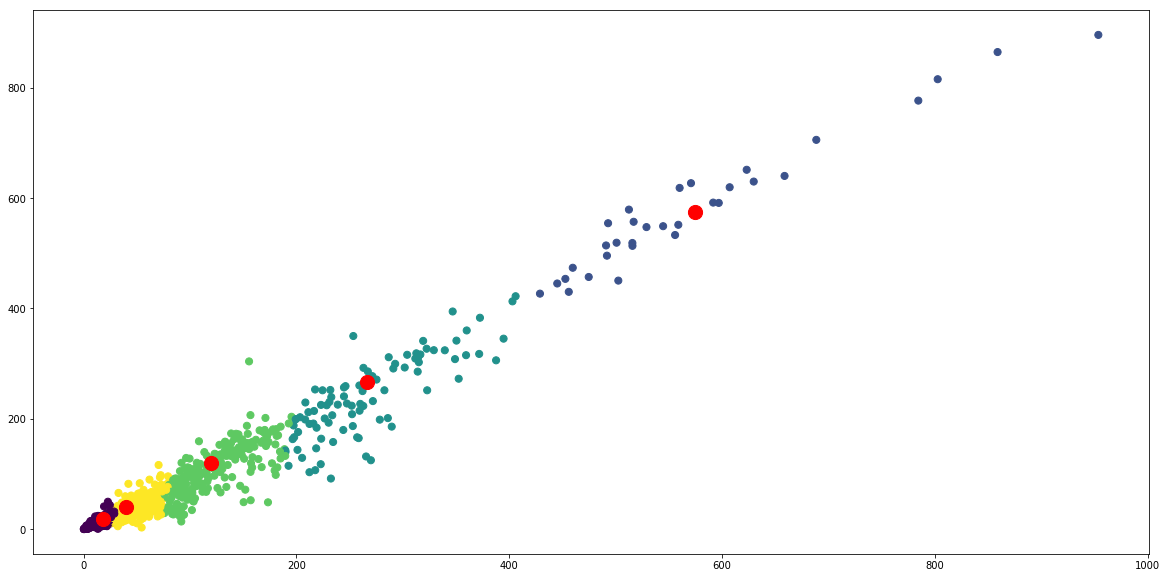

In [20]:
plt.figure(figsize=(20,10))
#plt.scatter(quartelyAverages[:,0],quartelyAverages[:,1],quartelyAverages[:,2],quartelyAverages[:,3], label='True Position')  
kmeans = KMeans(n_clusters=5)  
kmeans.fit(features)
#features['Cluster'] = kmeans.fit_predict(features)
#y_kmeans = kmeans.fit_predict(features)
#print(kmeans.cluster_centers_)  
#print(kmeans.labels_)

centers = kmeans.cluster_centers_;
#print(centers)
plt.scatter(features[:, 0], features[:, 3], c=kmeans.labels_,s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 0],c='red', s=200);

index, counts = np.unique(kmeans.labels_,return_counts=True)
i=0
for c in index:
    print("Cluster %d number of consumers %d" % (c, counts[i]))
    i=i+1


In [21]:
features = dfUserGroup.iloc[:, 1:]
k_means = KMeans(n_clusters = 5).fit(features) #Using 3 clusters, change this after adding more features.
features['Cluster'] = k_means.fit_predict(features)
print(features.head())
features.Cluster.value_counts()

   DailyAvgPerUser  Cluster
0        10.290438        3
1         9.496968        3
2         9.986623        3
3        30.420860        0
4        47.250825        0


3    3926
0    2135
4     252
2      90
1      32
Name: Cluster, dtype: int64

**Hierarchical clustering**

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [23]:
feature1 = dfElectricityUsage.iloc[:,1:]
feature1

,DailyAvgPerUser,Q1Avg,Q2Avg,Q3Avg,Q4Avg,MonAvg,TueAvg,WedAvg,ThursAvg,FriAvg,...,aprAvg,mayAvg,junAvg,julAvg,augAvg,sepAvg,octAvg,novAvg,desAvg,weekendAvg
0,10.290,12.185,7.887,8.705,12.026,10.029,10.494,10.596,9.204,9.957,...,8.411,7.647,7.611,8.432,8.774,8.856,10.585,11.252,14.217,10.290
1,9.497,6.741,4.394,5.031,17.520,9.461,9.494,9.447,9.660,9.818,...,5.031,4.091,4.069,5.050,4.959,5.089,5.178,11.673,35.519,9.497
2,9.987,11.042,9.663,9.457,10.122,11.068,10.070,11.134,10.555,9.708,...,8.100,10.226,10.644,9.944,9.245,9.280,8.675,11.423,10.311,9.987
3,30.421,34.442,29.878,26.479,32.386,31.206,29.749,30.105,30.416,29.647,...,32.630,32.623,24.291,26.465,25.851,27.139,29.507,32.247,35.399,30.421
4,47.251,45.987,41.710,48.071,49.847,48.756,46.630,47.365,44.976,42.407,...,37.611,45.338,42.059,45.919,47.646,50.268,48.738,49.455,51.335,47.251
5,29.968,39.393,22.774,22.066,36.259,29.648,30.446,30.519,28.193,27.248,...,21.622,23.677,22.994,22.217,20.611,23.448,27.614,37.748,43.464,29.968
6,21.491,29.277,12.956,15.666,27.316,22.085,21.357,20.090,21.062,22.943,...,17.202,15.096,6.498,14.506,15.255,17.037,21.187,25.487,35.215,21.491
7,34.972,39.329,35.157,31.546,35.935,33.781,32.210,33.279,33.291,34.230,...,33.965,34.926,36.587,28.262,34.449,31.227,31.856,36.186,39.770,34.972
8,35.155,41.770,30.745,28.937,39.880,34.854,36.031,34.399,32.707,33.950,...,34.497,29.669,28.106,28.417,28.202,30.120,34.077,38.892,46.639,35.155
9,40.109,41.689,29.571,37.983,46.522,37.403,39.877,39.291,40.590,39.292,...,30.650,28.860,29.227,34.060,38.974,40.164,43.952,46.779,48.843,40.109


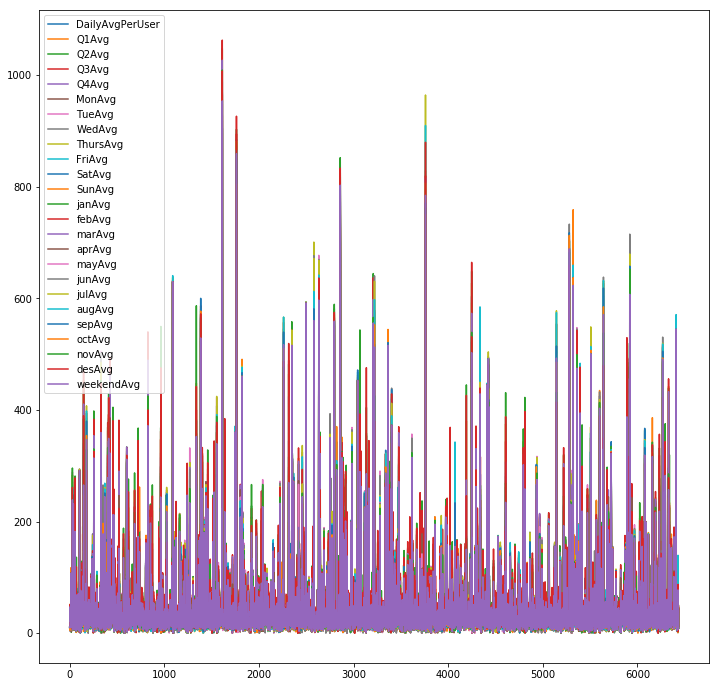

In [24]:
feature1.plot(figsize=(12,12))

In [25]:
Z= linkage(feature1, 'ward')


**'ward' is one of the methods that can be used to calculate the distance between newly formed clusters.
The keyword ‘ward’ causes linkage function to use the Ward variance minimization algorithm.
Other common linkage methods like single, complete, average, and different distance metrics such as euclidean, manhattan, hamming, cosine are also available if you want to play around with.

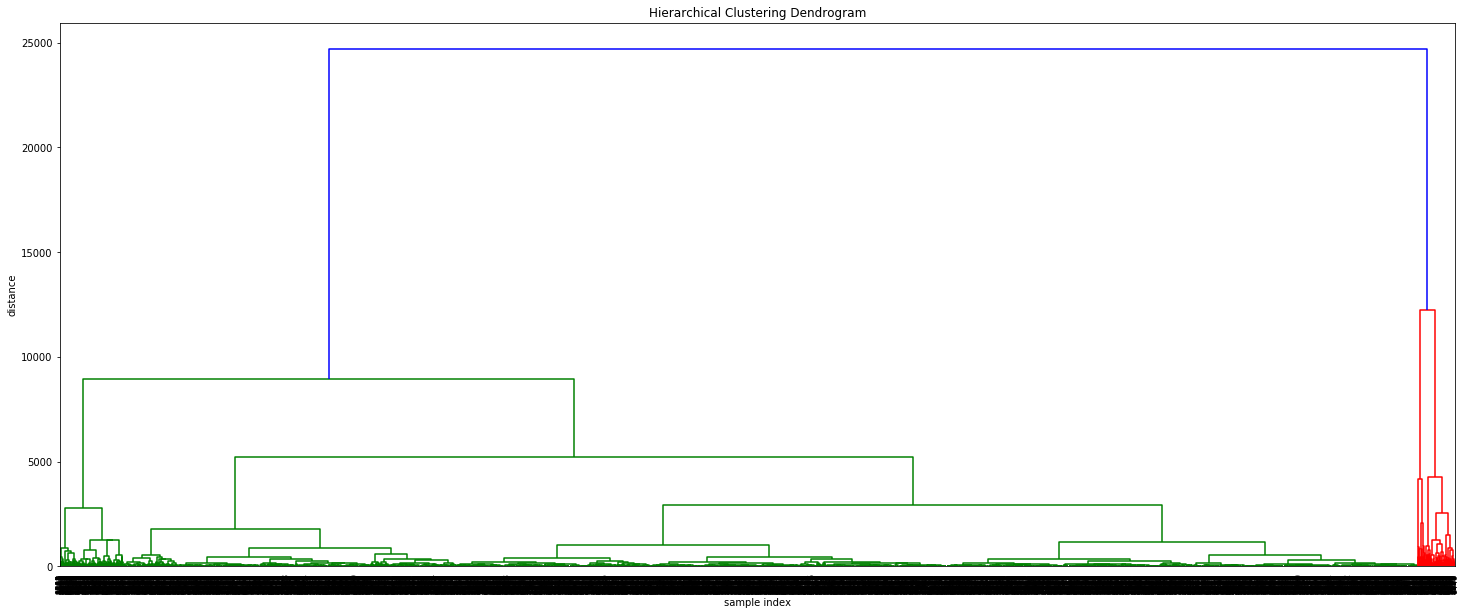

In [26]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

In [27]:
#Retreiving the Clusters using fcluster function
from scipy.cluster.hierarchy import fcluster

def print_clusters(feature1, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of consumers %d" % (c, len(cluster_indeces)))
        if plot:
            feature1.T.iloc[:,cluster_indeces].plot()
            plt.show()

print_clusters(feature1, Z, 9, plot=False)

Cluster 5 number of consumers 2175
Cluster 4 number of consumers 2258
Cluster 3 number of consumers 1541
Cluster 2 number of consumers 206
Cluster 9 number of consumers 112
Cluster 8 number of consumers 25
Cluster 1 number of consumers 86
Cluster 7 number of consumers 28
Cluster 6 number of consumers 4


## FBProphet Time Series Prediction ##

In [31]:
# Adding cluster as a column to original dataset 
dfElectricityUsage['cluster']=features['Cluster']


#finding mean grouped by clsuter to show the variation of usage between clusters
print(dfElectricityUsage[dfElectricityUsage.columns[1:]].groupby(['cluster']).agg([np.mean]))


dfNew = dfElectricityUsage
dfElectricityUsage.set_index('Meter ID')
dfElectricityUsage.set_index('Meter ID')
# Merging our original dataset to the processed one , so that we get all features and cluster for the Meter ID
dfNew =dfElectricalUsage.merge(dfElectricityUsage , how ='inner')

#making seperate datagrame for each cluster
col_list = ['date','DailyUsage']
dfUserGroupClus1 = dfNew[(dfNew['cluster']==0)]
dfUserGroupClus1 = dfUserGroupClus1[col_list]
dfUserGroupClus1.columns=['ds','y']
dfUserGroupClus2 = dfNew[(dfNew['cluster']==1)]
dfUserGroupClus2 = dfUserGroupClus2[col_list]
dfUserGroupClus2.columns=['ds','y']
dfUserGroupClus3 = dfNew[(dfNew['cluster']==2)]
dfUserGroupClus3 = dfUserGroupClus3[col_list]
dfUserGroupClus3.columns=['ds','y']
dfUserGroupClus4 = dfNew[(dfNew['cluster']==3)]
dfUserGroupClus4 = dfUserGroupClus4[col_list]
dfUserGroupClus4.columns=['ds','y']
dfUserGroupClus5 = dfNew[(dfNew['cluster']==4)]
dfUserGroupClus5 = dfUserGroupClus5[col_list]
dfUserGroupClus5.columns=['ds','y']



        DailyAvgPerUser       Q1Avg       Q2Avg       Q3Avg       Q4Avg  \
                   mean        mean        mean        mean        mean   
cluster                                                                   
0             39.471038   44.480380   35.114046   34.779933   43.535310   
1            574.155062  575.333813  566.507375  581.045813  570.956656   
2            267.652633  306.817289  245.971844  241.863689  283.185400   
3             17.717657   19.587566   15.559815   15.869971   19.587361   
4            122.149774  146.045933  112.001687  107.060933  129.503079   

             MonAvg      TueAvg      WedAvg    ThursAvg      FriAvg  \
               mean        mean        mean        mean        mean   
cluster                                                               
0         39.467315   40.007286   39.706134   39.455195   39.298940   
1        577.113500  585.385531  586.376719  601.930875  596.590531   
2        278.234111  290.434867  289.125356 

In [30]:
def plot_data(data_cluster):
    timeseries=data_cluster.copy()
    timeseries.columns=['date','Total Daily KW']
    timeseries = timeseries.set_index('date') 
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(timeseries.index,timeseries['Total Daily KW'],c='black',s=2)


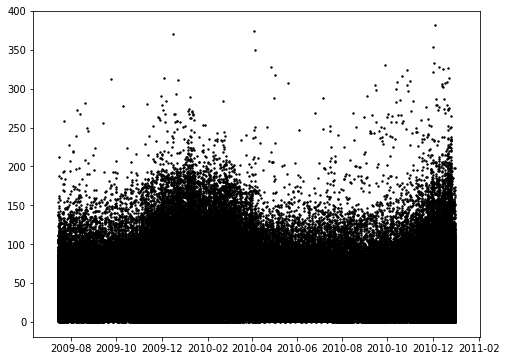

In [40]:
plot_data(dfUserGroupClus1)

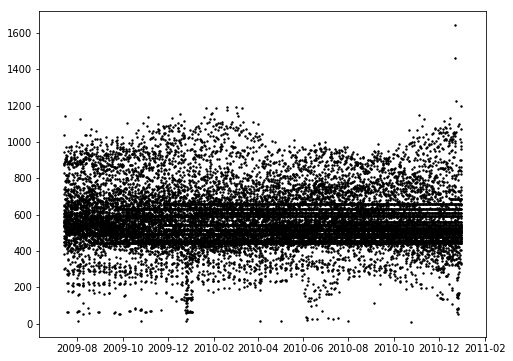

In [41]:
plot_data(dfUserGroupClus2)

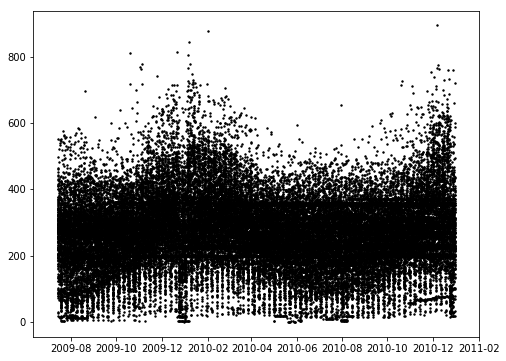

In [42]:
plot_data(dfUserGroupClus3)

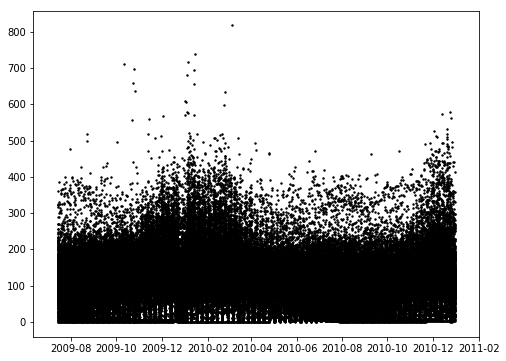

In [43]:
plot_data(dfUserGroupClus4)

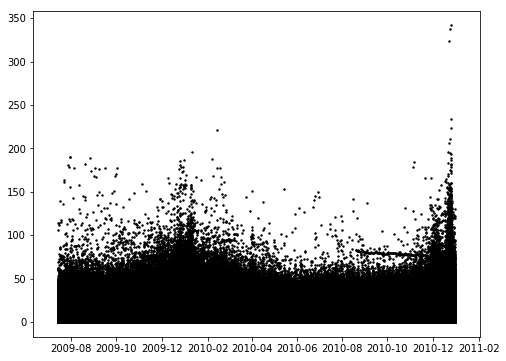

In [44]:
plot_data(dfUserGroupClus5)

In [46]:
import fbprophet
from sklearn.metrics import mean_squared_error, r2_score
model = fbprophet.Prophet(daily_seasonality=False,weekly_seasonality=True,
                yearly_seasonality=True,changepoint_prior_scale=0.05,changepoints=None,interval_width=0.95)

In [47]:
size = len(dfUserGroupClus2) - 30

In [48]:
train, test = dfUserGroupClus2[0:size], dfUserGroupClus2[size:]

In [49]:
test_=test.set_index('ds')

In [50]:
model.fit(train)

/Users/alexanthony/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [52]:
predics=model.predict(dfUserGroupClus2)

In [57]:
test=pd.merge(test,predics[['ds','yhat','yhat_lower','yhat_upper']],how='left',on='ds')

In [56]:
train=pd.merge(train,predics[['ds','yhat','yhat_lower','yhat_upper']],how='left',on='ds')
    

In [58]:
RMSE=np.sqrt(mean_squared_error(test['y'], test['yhat']))
print('RMSE = %.2f' % RMSE)

RMSE = 33.60


In [59]:
R2=r2_score(test['y'], test['yhat'])
print('R Square = %.2f'% R2)

R Square = -87350767700949915749293490176.00


In [60]:
future = model.make_future_dataframe(periods=30, freq='D')

In [61]:
future=model.predict(future)

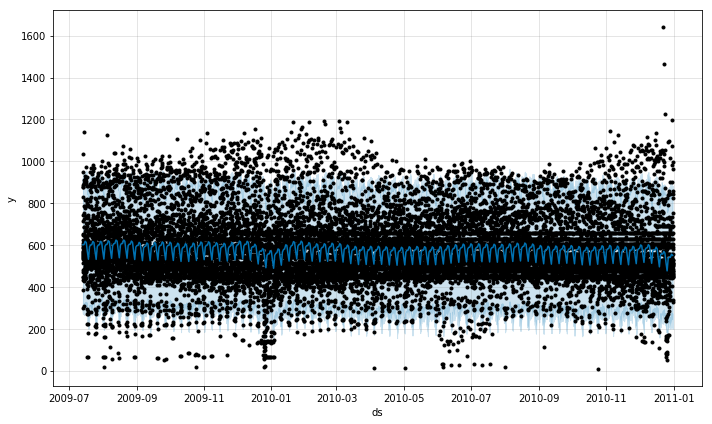

In [62]:
fig=model.plot(predics)

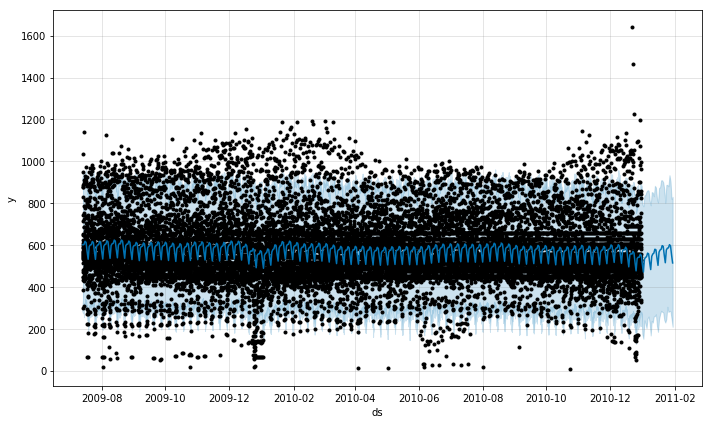

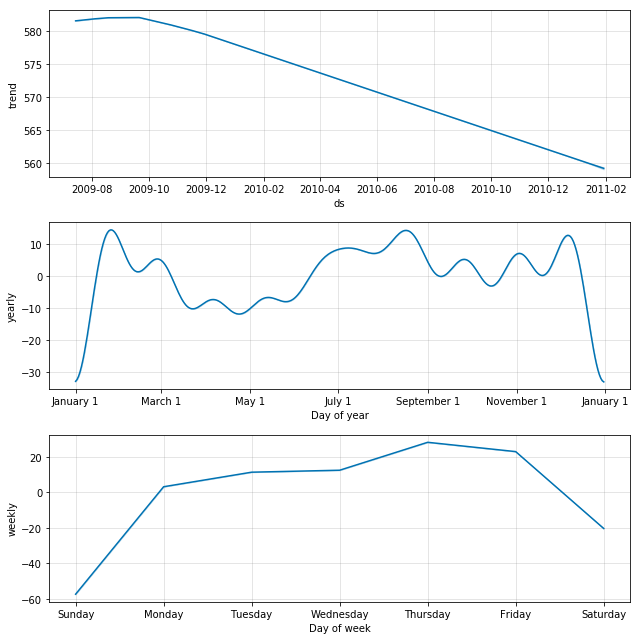

In [64]:
    fig2=model.plot(future)
    plt.scatter(test_.index,test_['y'],c='black',s=7)
    fig3=model.plot_components(future)